In [ ]:
%pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuração Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

1. Carregamento dos Dados Processados

    Importei a série temporal mensal gerada na etapa de Análise Exploratória.

In [3]:
# Carregando
df = pd.read_csv('../data/vendas_mensais.csv', index_col='Order Date', parse_dates=True)

df.index.freq = 'MS' 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2019-01-01 to 2022-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Quantity  48 non-null     int64
dtypes: int64(1)
memory usage: 768.0 bytes


2. Divisão Treino vs Teste (Backtesting)

    Para validar o modelo, simulei uma viagem no tempo.

    Treino: Dados de 2014 até final de 2016.
    
    Teste: O ano de 2017 inteiro (12 meses). O modelo tentará prever 2017 sem nunca ter visto esses dados.

In [4]:
# Definindo o horizonte de previsão (12 meses)
meses_teste = 12

treino = df.iloc[:-meses_teste]
teste = df.iloc[-meses_teste:]

print(f"Período de Treino: {treino.index.min().date()} até {treino.index.max().date()}")
print(f"Período de Teste:  {teste.index.min().date()} até {teste.index.max().date()}")

Período de Treino: 2019-01-01 até 2021-12-01
Período de Teste:  2022-01-01 até 2022-12-01


3. Criação dos Modelos;

  Testarei duas hipóteses de sazonalidade:

    Modelo Aditivo: Assume que o aumento nas vendas sazonais é fixo (ex: +100 unidades).

    Modelo Multiplicativo: Assume que o aumento é proporcional (ex: +10% sobre o volume atual).

    Dado o crescimento da empresa visto na análise exploratória, espera-se que o Multiplicativo performe melhor.

In [5]:
# --- Modelo 1: Aditivo (BModelo usado anteriormente) ---
modelo_add = ExponentialSmoothing(
    treino['Quantity'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()
pred_add = modelo_add.forecast(steps=meses_teste)

# --- Modelo 2: Multiplicativo (Modelo novo) ---
modelo_mul = ExponentialSmoothing(
    treino['Quantity'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit()
pred_mul = modelo_mul.forecast(steps=meses_teste)

4. Comparação Visual: Realidade vs Previsão
    O gráfico abaixo sobrepõe as previsões aos dados reais de 2017 (Dados de Teste).

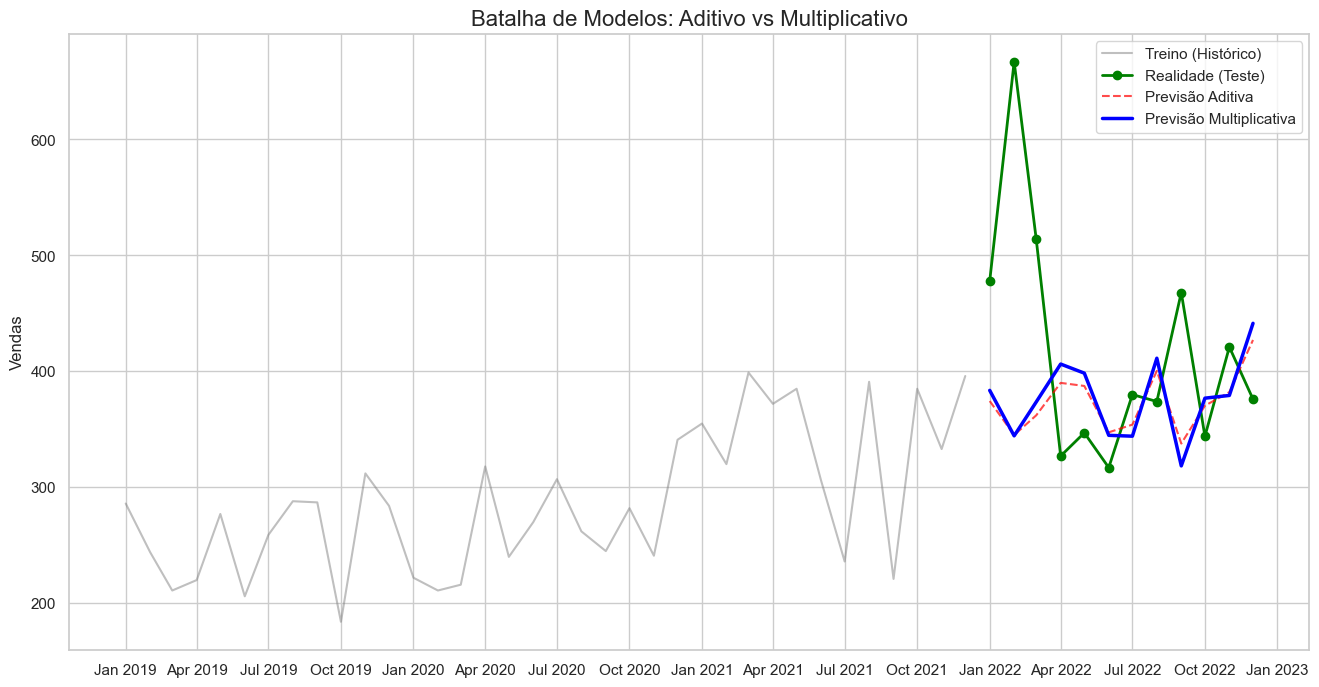

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

# 1. Dados de Treino (Histórico)
ax.plot(treino.index, treino['Quantity'], label='Treino (Histórico)', color='gray', alpha=0.5)

# 2. Dados Reais (O gabarito)
ax.plot(teste.index, teste['Quantity'], label='Realidade (Teste)', color='green', linewidth=2, marker='o')

# 3. Previsão Aditiva
ax.plot(teste.index, pred_add, label='Previsão Aditiva', color='red', linestyle='--', alpha=0.7)

# 4. Previsão Multiplicativa
ax.plot(teste.index, pred_mul, label='Previsão Multiplicativa', color='blue', linewidth=2.5, linestyle='-')

# Formatação de Datas
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title('Batalha de Modelos: Aditivo vs Multiplicativo', fontsize=16)
plt.ylabel('Vendas')
plt.legend()
plt.show()

5. Scorecard (Avaliação Matemática)

    Utilizei o MAPE (Mean Absolute Percentage Error) para definir o vencedor. Ele indica, em média, quantos % o modelo erra.

In [7]:
def calcular_mape(y_real, y_pred):
    return np.mean(np.abs((y_real - y_pred) / y_real)) * 100

mape_add = calcular_mape(teste['Quantity'], pred_add)
mape_mul = calcular_mape(teste['Quantity'], pred_mul)

print(f"Erro Modelo Aditivo:        {mape_add:.2f}%")
print(f"Erro Modelo Multiplicativo: {mape_mul:.2f}%")

melhor_modelo = "Multiplicativo" if mape_mul < mape_add else "Aditivo"
print(f"\n🏆 Vencedor: Modelo {melhor_modelo}")

Erro Modelo Aditivo:        17.69%
Erro Modelo Multiplicativo: 19.30%

🏆 Vencedor: Modelo Aditivo


6. Teste real

    Agora que validei que o modelo Aditivo é superior, vamos retreiná-lo com TODOS os dados (Treino + Teste) para prever o ano de 2018 real.

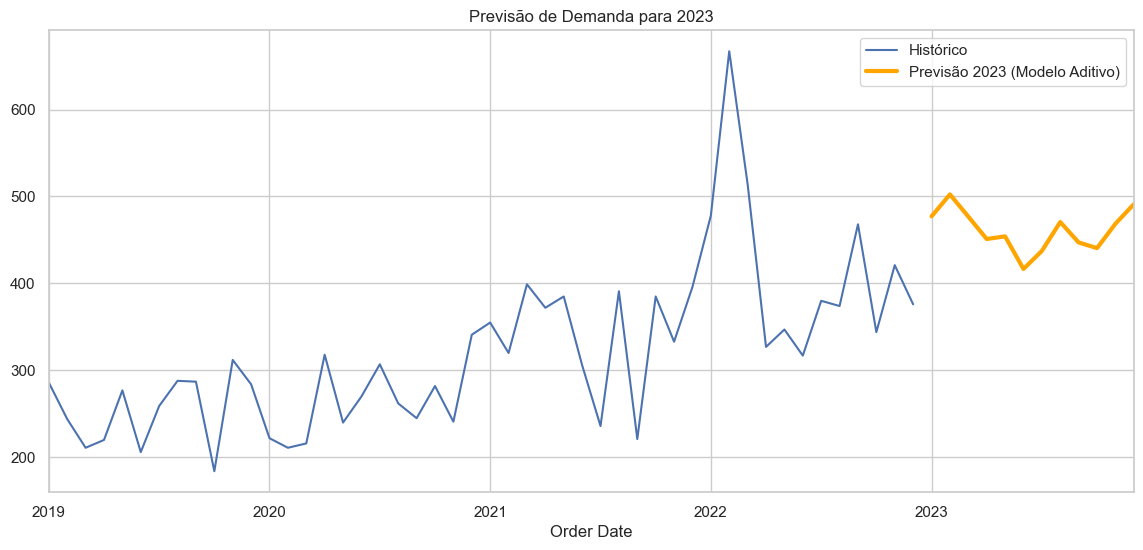

Previsão Final salva com sucesso!


In [10]:
# Treinando com o dataset COMPLETO (até a última data disponível)
modelo_final = ExponentialSmoothing(
    df['Quantity'],
    trend='add', 
    seasonal='add',  # <--- MUDAMOS AQUI PARA O VENCEDOR
    seasonal_periods=12
).fit()

# Prevendo 12 meses para frente (2018)
forecast_2018 = modelo_final.forecast(steps=12)

# Plotando e Exportando
fig, ax = plt.subplots(figsize=(14, 6))
df['Quantity'].plot(ax=ax, label='Histórico')
forecast_2018.plot(ax=ax, label='Previsão 2023 (Modelo Aditivo)', color='orange', linewidth=3)
plt.title('Previsão de Demanda para 2023')
plt.legend()
plt.show()

forecast_2018.to_csv('../data/previsao_2018.csv')
print("Previsão Final salva com sucesso!")